# **STEP 0: IMPORT LIBRARIES**

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.
Sao chép

This Markdown cell can be copied into a Jupyter Notebook or any Markdown editor to provide a comprehensive overview of the script's functionality.
nhồi nó vào 1 cell

GPT-4o
Sure! Here is the entire README content formatted as a single Markdown cell:

Sao chép
# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.

# **STEP 1: DEFINE LABEL**

In [222]:
forex_label = ['GBPJPY=X'] # You can update by adding more

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [223]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [224]:
file_path, data = crawl_forex_data(forex_label)

# Display the first 10 rows of the DataFrame
print(data.head(5))
print(data.info())

# Calculate and print statistics of NaN values
nan_stats = data.isna().sum()
total_nans = nan_stats.sum()

print("\nStatistics of NaN values in the DataFrame:")
print(nan_stats)
print(f"\nTotal number of NaN values: {total_nans}")

[*********************100%***********************]  1 of 1 completed

Saved data for ['GBPJPY=X'] at Dataset\['GBPJPY=X']_data.csv
        Date       Open       High        Low      Close  Adj Close  Volume
0 2003-12-01 189.330002 189.660004 187.740005 187.630005 187.630005       0
1 2003-12-02 187.669998 188.809998 187.559998 188.009995 188.009995       0
2 2003-12-03 188.020004 188.240005 186.490005 187.089996 187.089996       0
3 2003-12-04 187.029999 187.029999 185.899994 186.220001 186.220001       0
4 2003-12-05 186.190002 186.740005 185.830002 185.880005 185.880005       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5424 non-null   datetime64[ns]
 1   Open       5424 non-null   float64       
 2   High       5424 non-null   float64       
 3   Low        5424 non-null   float64       
 4   Close      5424 non-null   float64       
 5   Adj Close  5424 non-null   float64       
 

**STEP 3: FEATURE ENGINEERING**

In [225]:
# Feature Engineering 
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()

# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

**3.2. Check NaN values before interpolation**

In [226]:
nan_stats_before = data.isna().sum()
total_nans_before = nan_stats_before.sum()
print("\nStatistics of NaN values before interpolation:")
print(nan_stats_before)
print(f"Total number of NaN values before interpolation: {total_nans_before}")


Statistics of NaN values before interpolation:
Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP               13
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Total number of NaN values before interpolation: 2045


**3.3. Use Interpolation to fill missing values**

**Why use Interpolation ?**

In [227]:
# Interpolate missing data
data.interpolate(method='linear', inplace=True)

In [228]:
# Check how many rows remain after interpolation
nan_stats_after = data.isna().sum()
total_nans_after = nan_stats_after.sum()
print("\nStatistics of NaN values after interpolation:")
# print(nan_stats_after)
print(f"Total number of NaN values after interpolation: {total_nans_after}")


Statistics of NaN values after interpolation:
Total number of NaN values after interpolation: 2032


**NOTE: As we can see, after using the interpolation, there are still many NaN values**

**3.4: Detect NaN values left and fill them**

In [229]:
# If there are still NaN values, use another method to fill them
if total_nans_after > 0:
    # Fill remaining NaN values with forward fill
    data.fillna(method='ffill', inplace=True)
    
    # If still NaN, use backward fill
    if data.isna().sum().sum() > 0:
        data.fillna(method='bfill', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25288\1693104163.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25288\1693104163.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


**3.5. Examine for left over NaN result**

In [230]:
# Final check on NaN values
nan_stats_final = data.isna().sum()
total_nans_final = nan_stats_final.sum()
print("\n----Statistics of NaN values after final filling----")
print(f"Total number of NaN values after final filling: {total_nans_final}")

# Check how many rows remain after dropping NaN values
data.dropna(subset=['Close', 'Open'], inplace=True)
print(f"Number of rows after dropna: {len(data)}")


----Statistics of NaN values after final filling----
Total number of NaN values after final filling: 0
Number of rows after dropna: 5424


**3.6. Define list of indicators**

In [231]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

**STEP 4: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [232]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [233]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [234]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**4.1. Plot out yearly data**

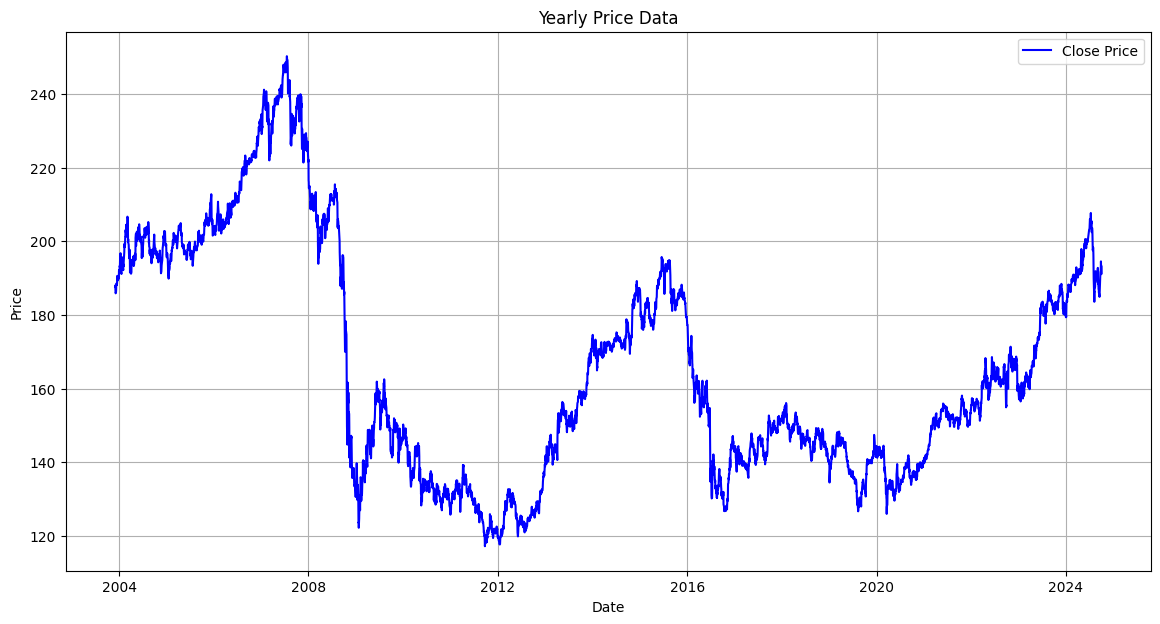

In [235]:
# Plot yearly data
plot_yearly_data(data)

**4..2. Plot out indicators vs price**

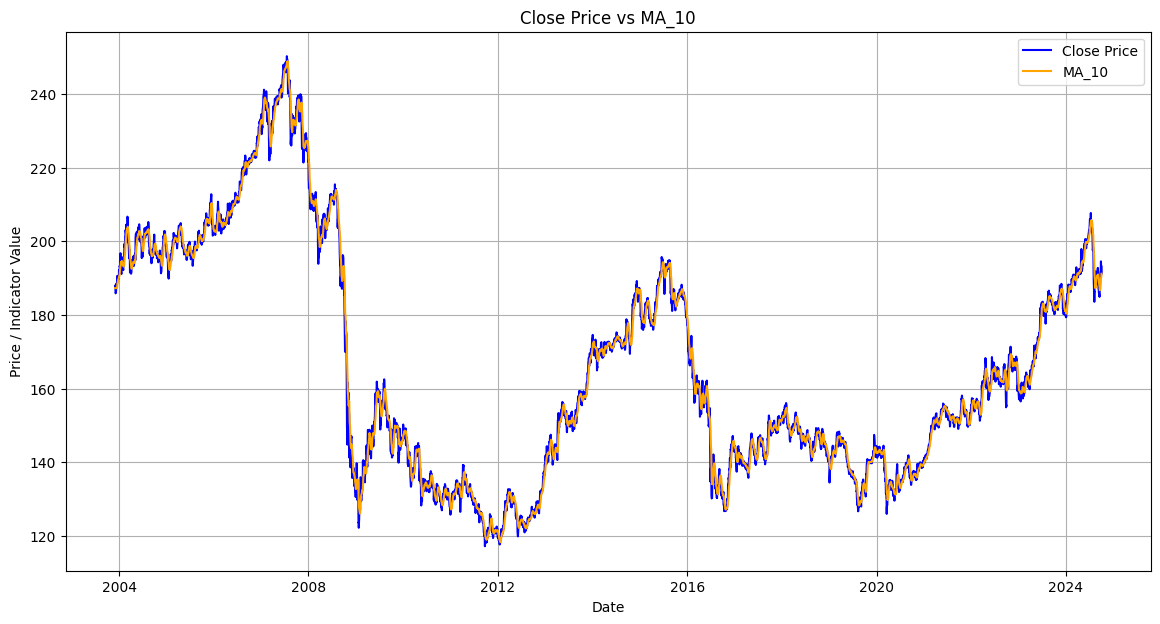

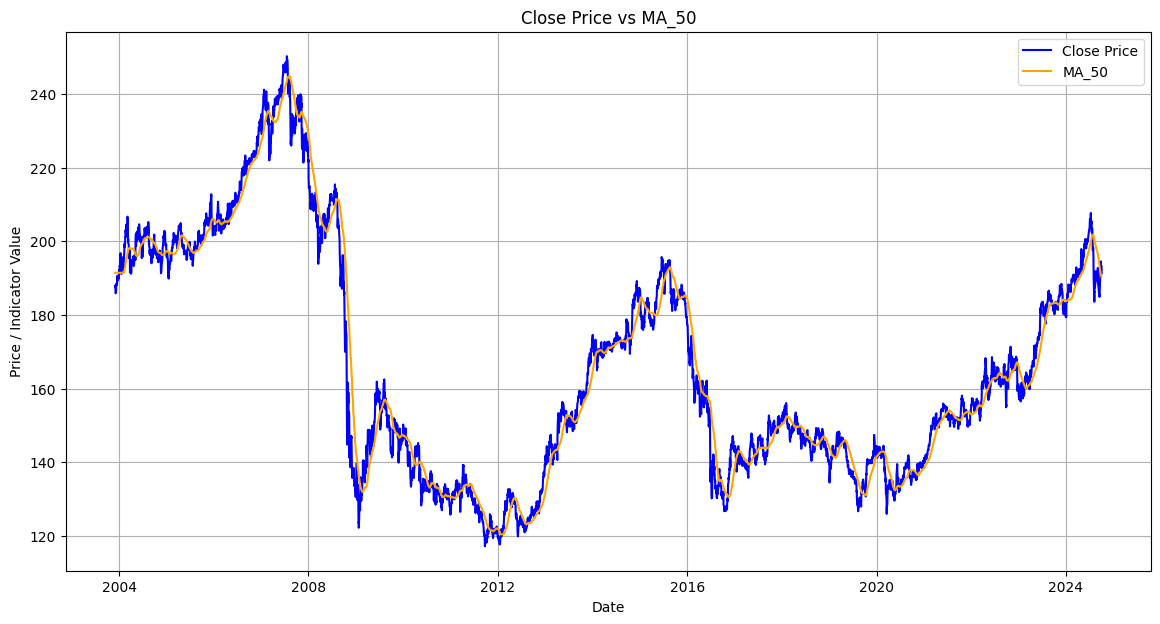

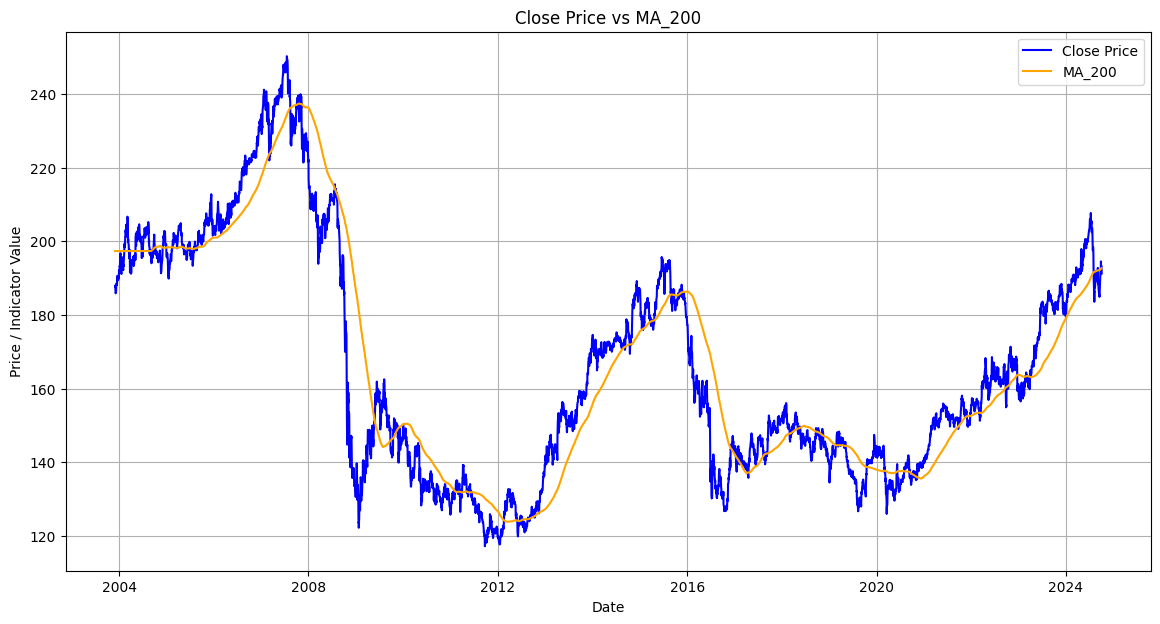

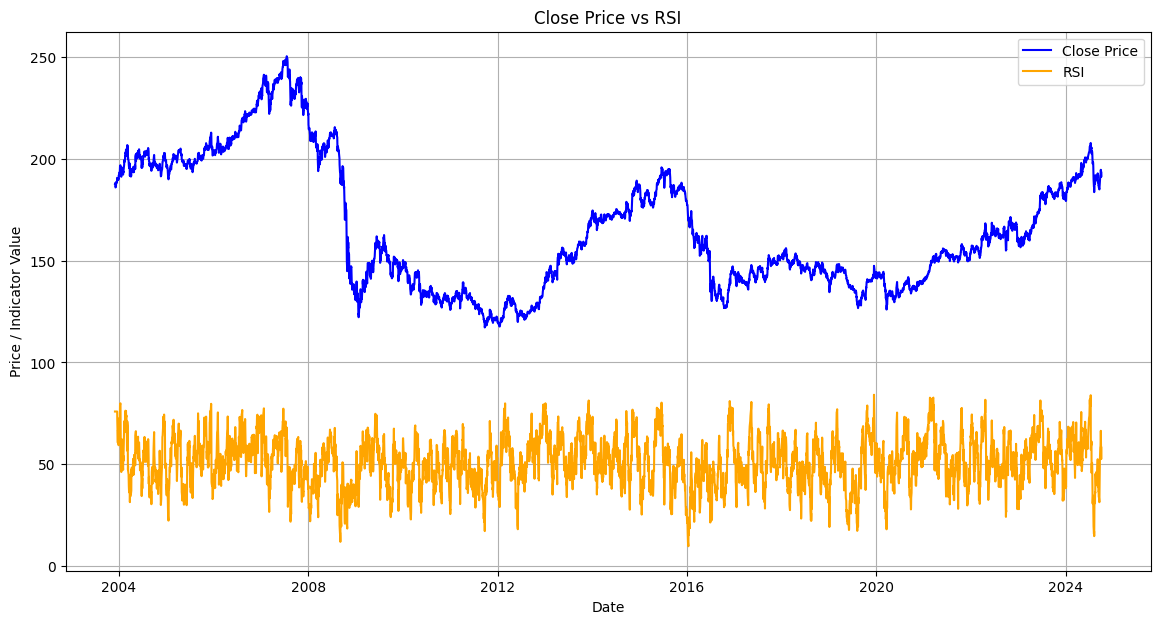

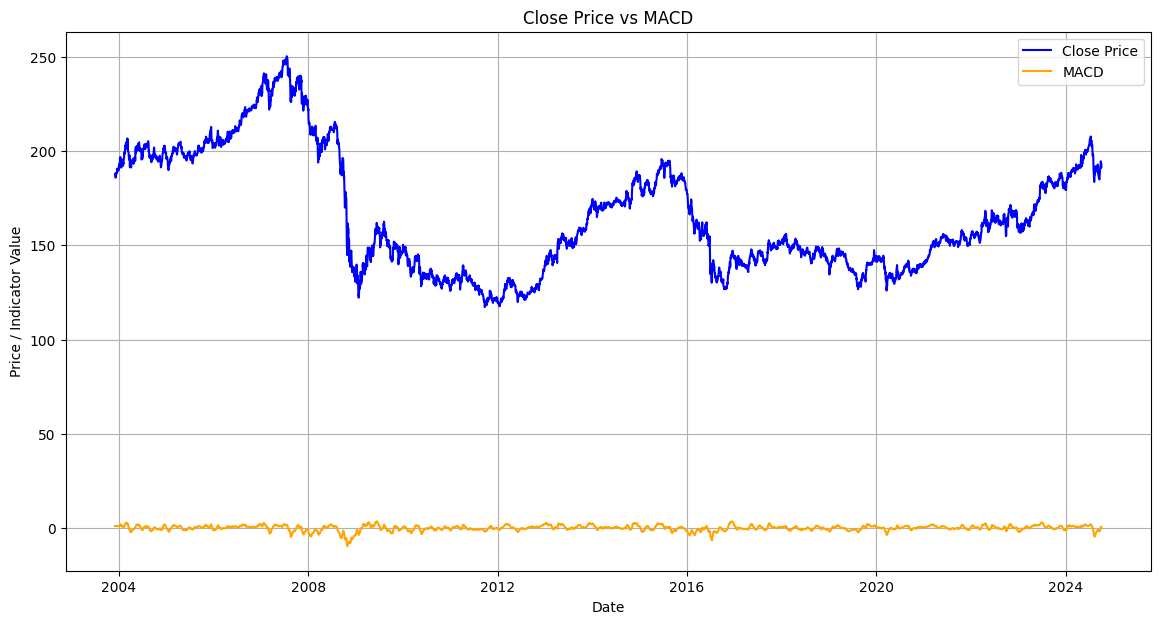

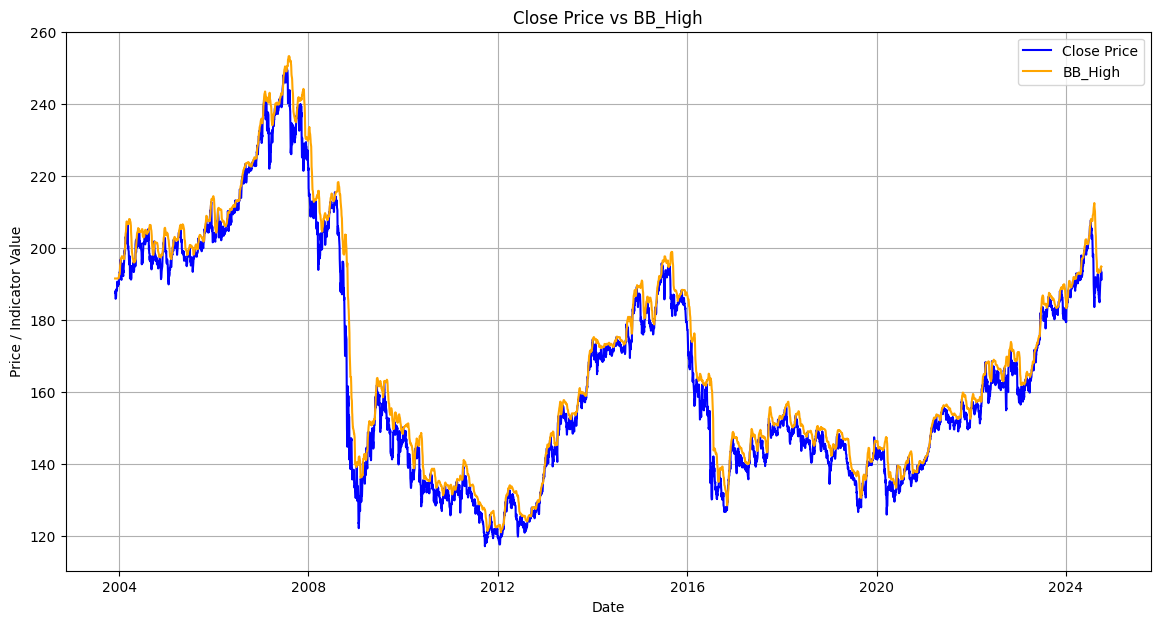

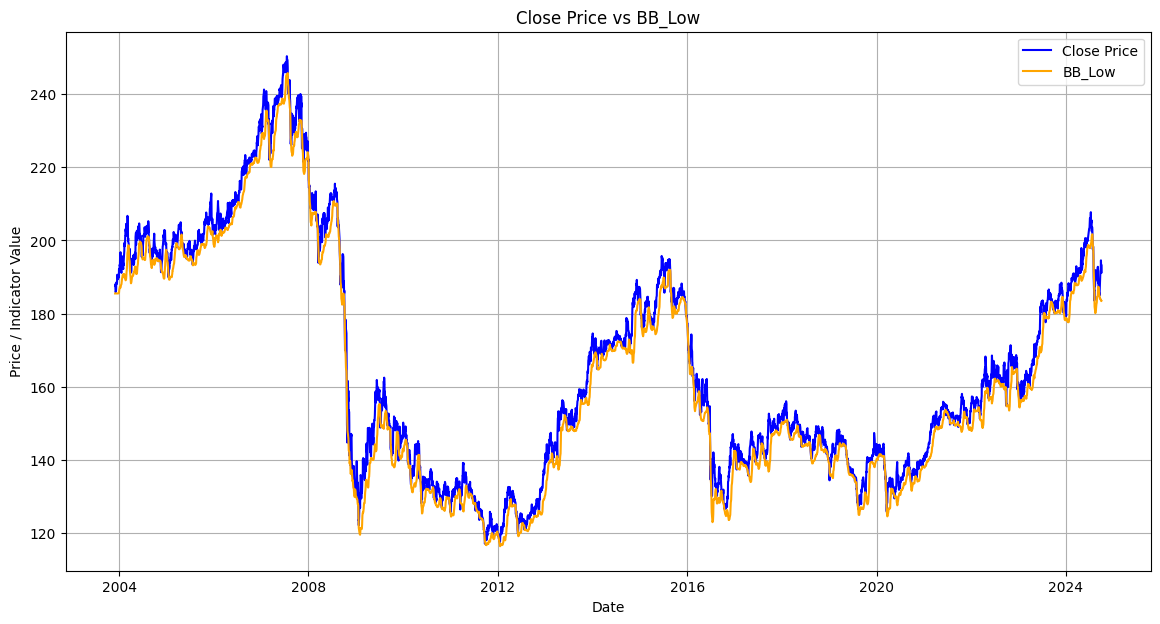

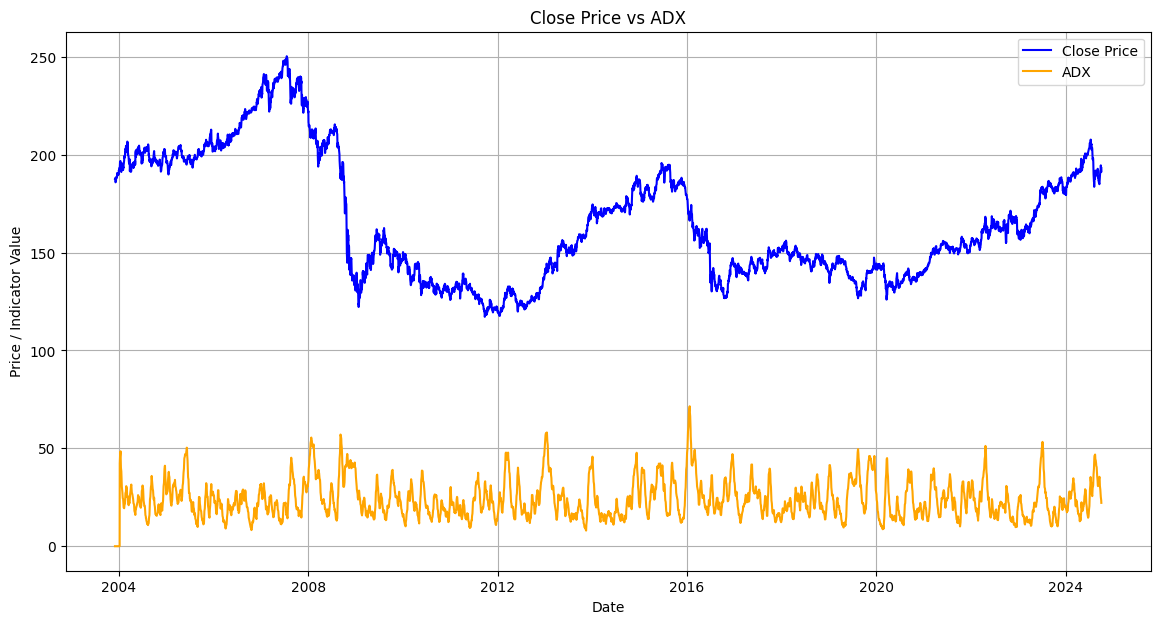

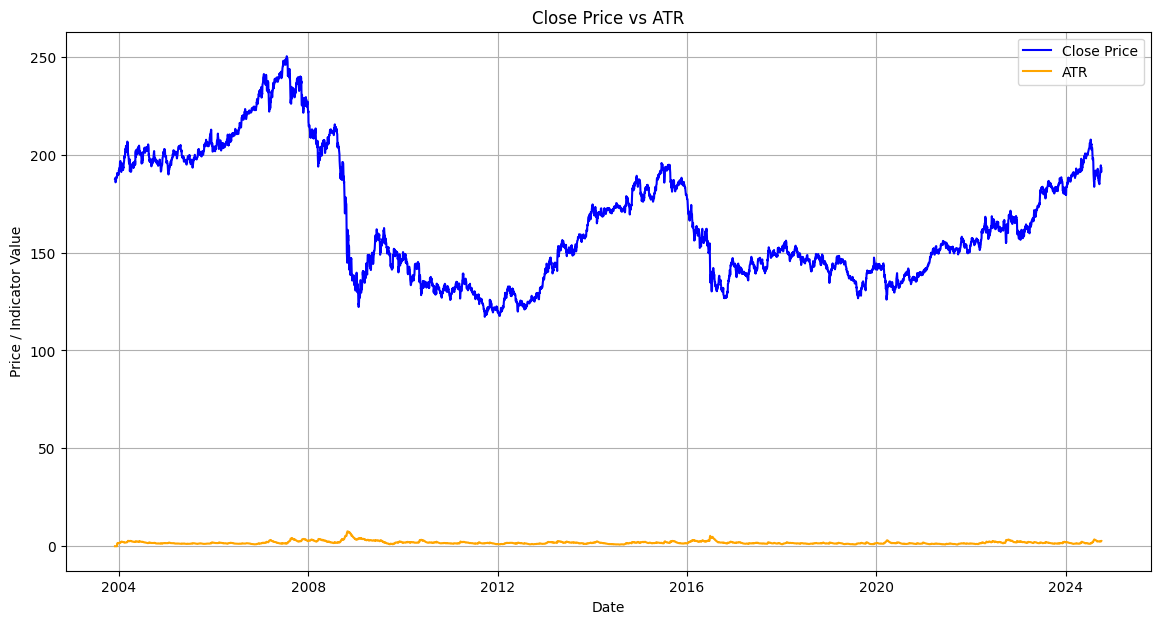

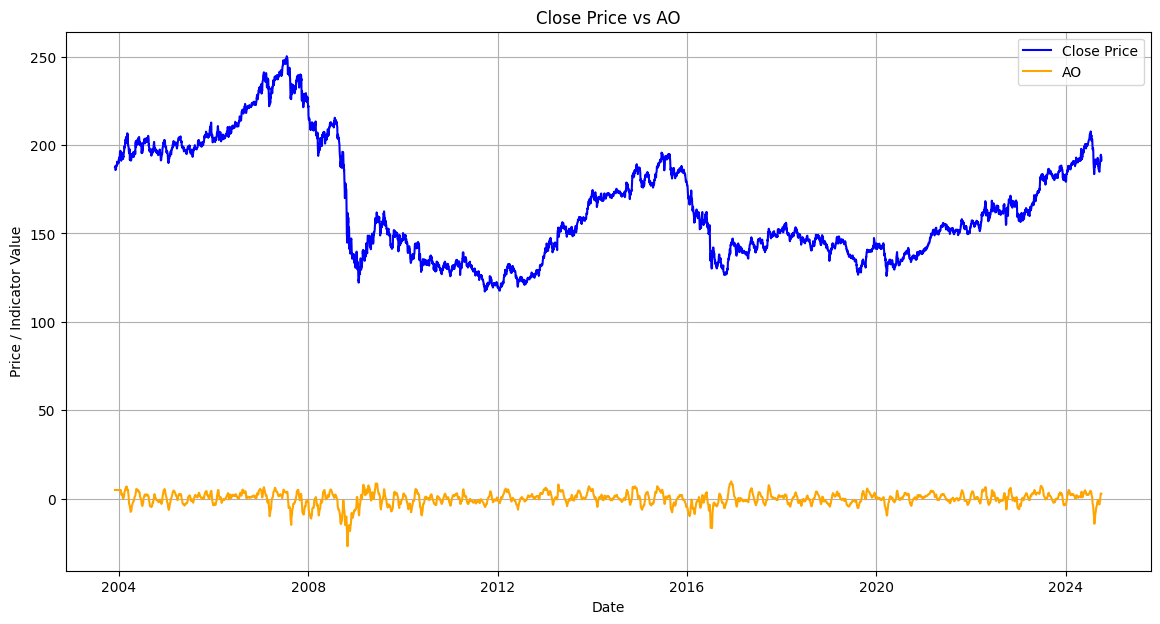

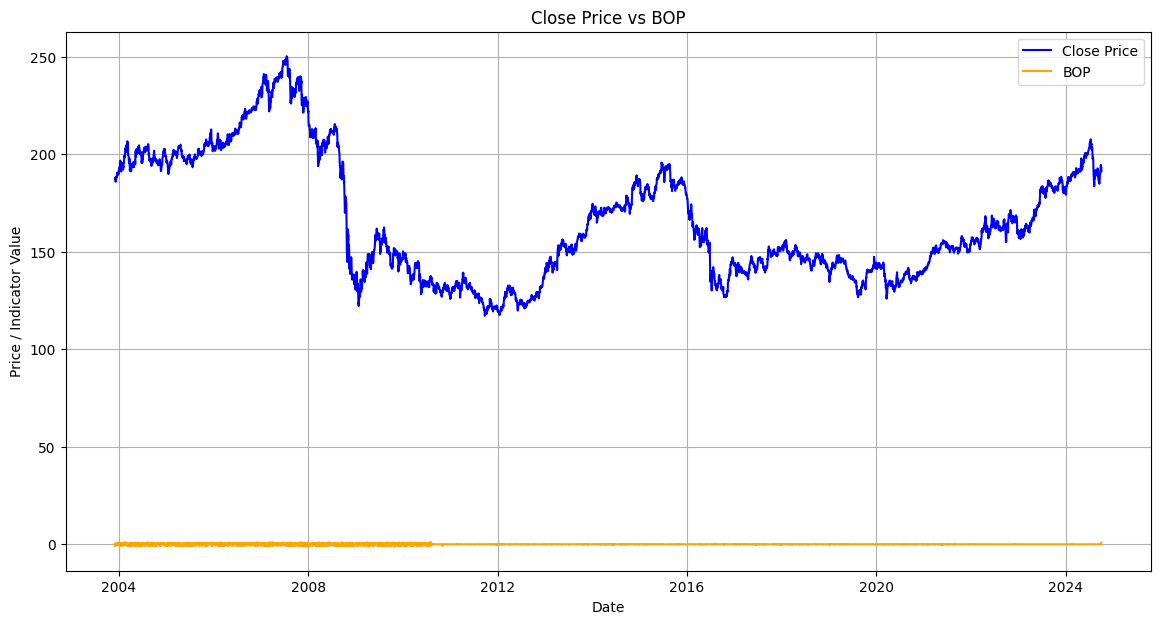

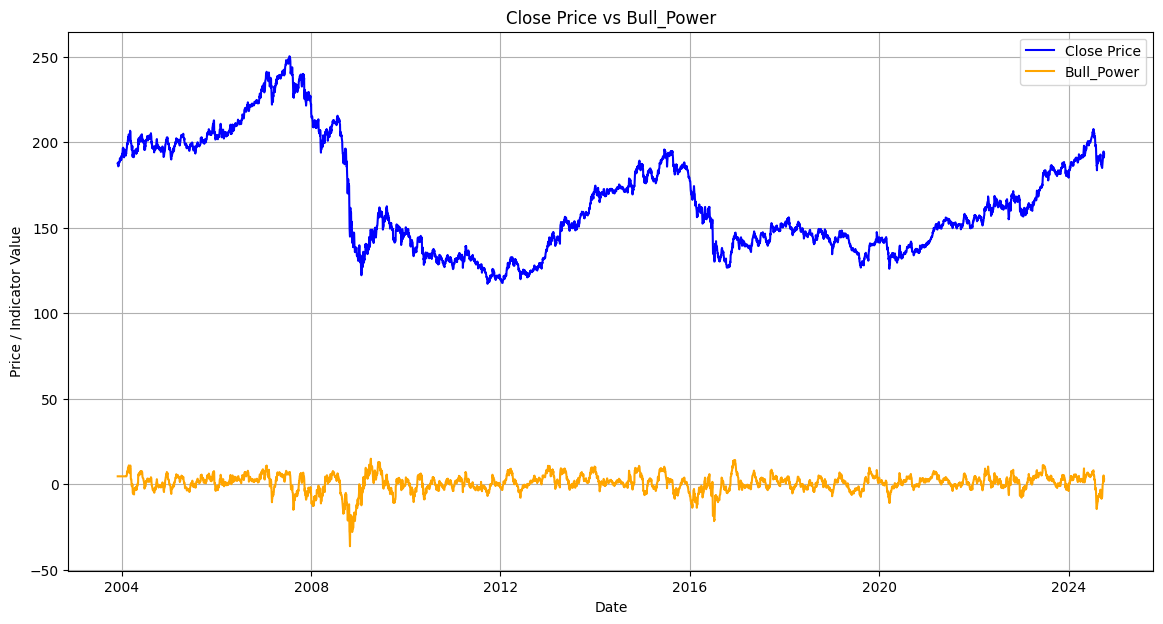

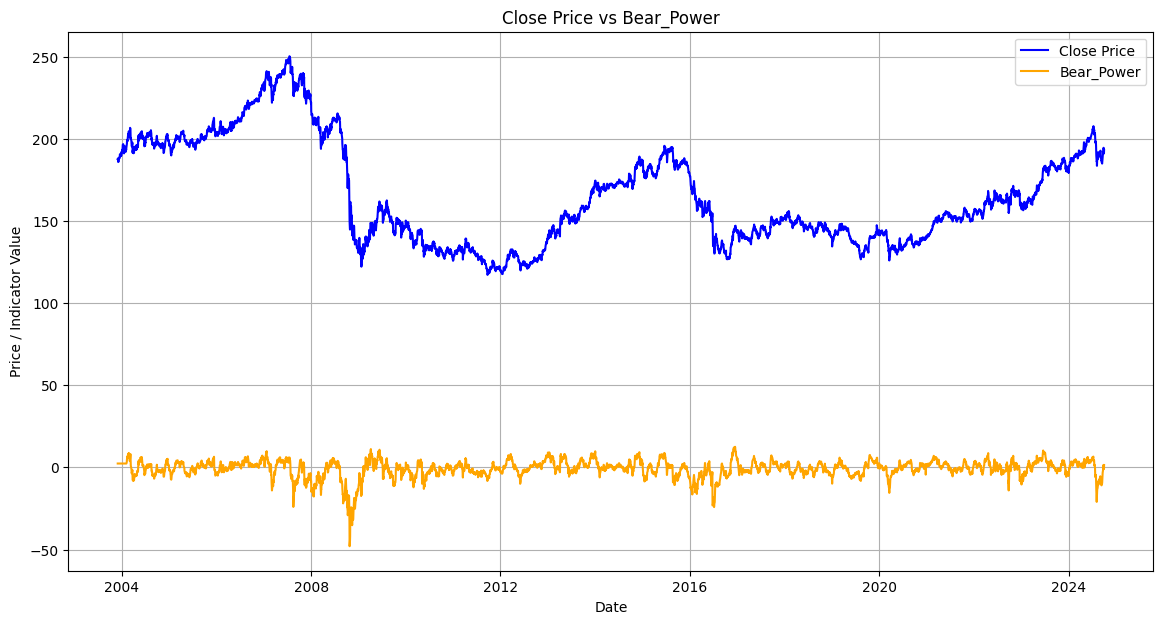

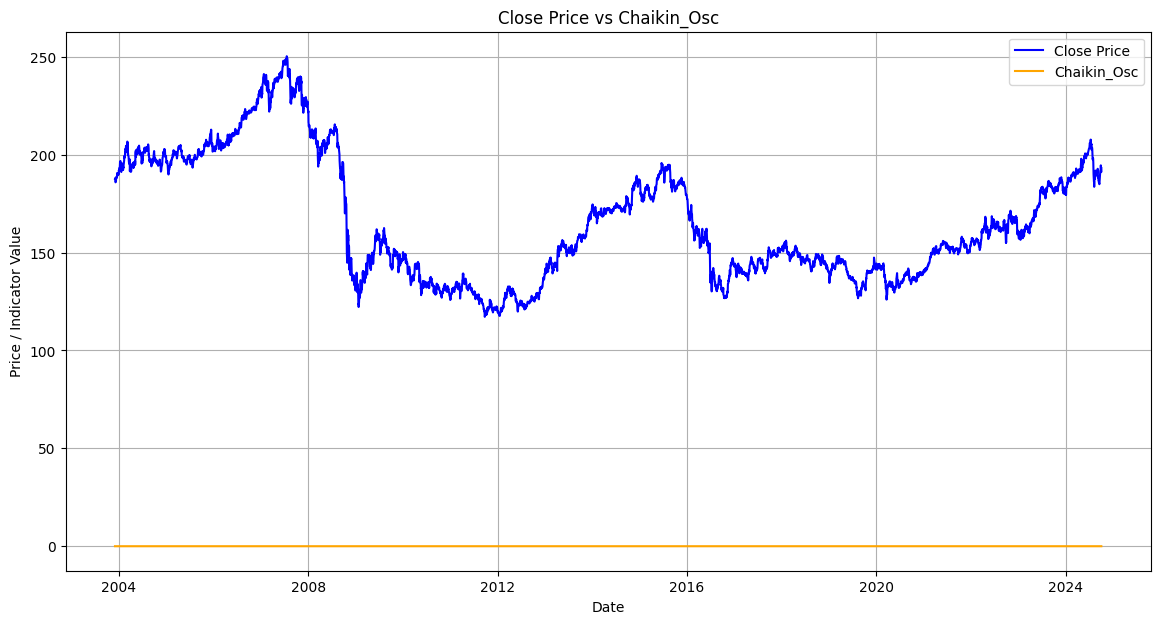

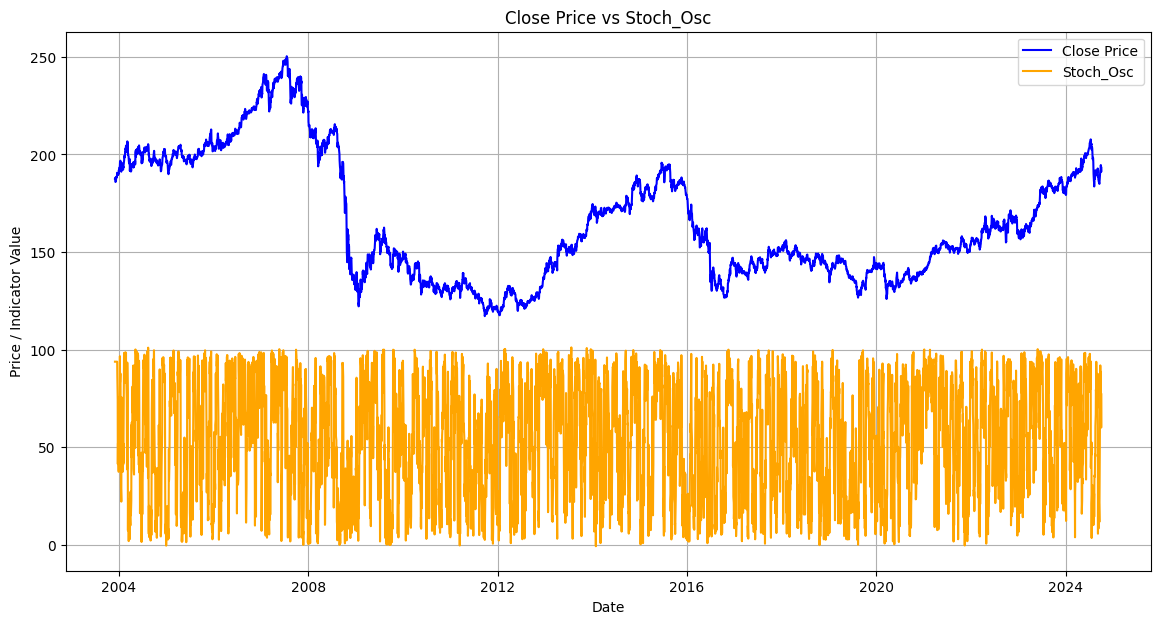

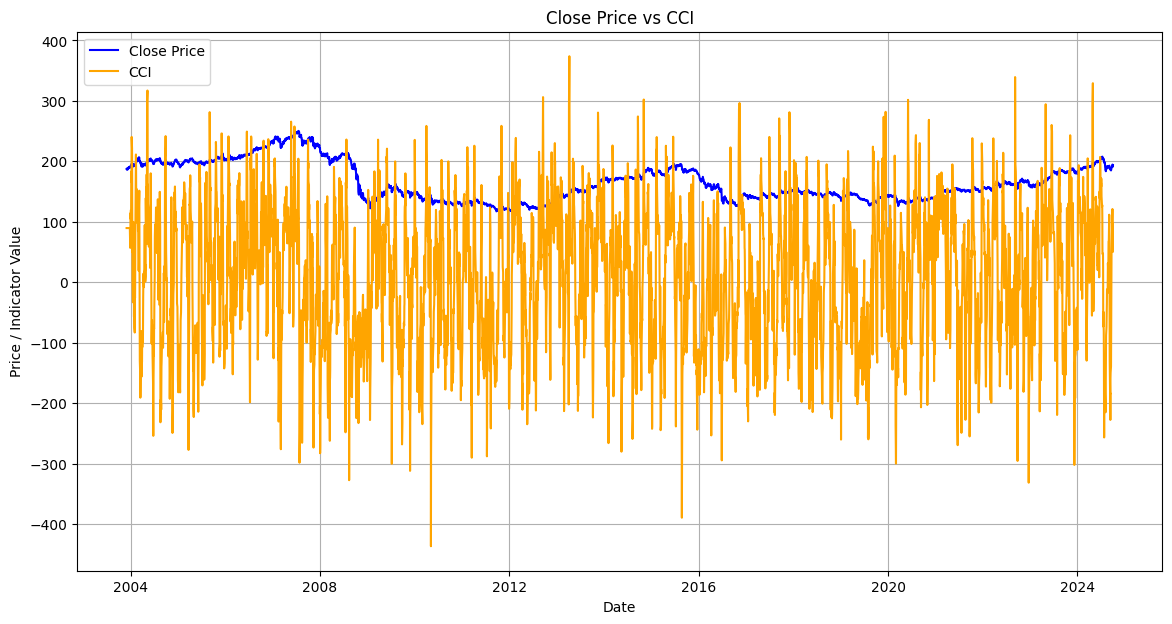

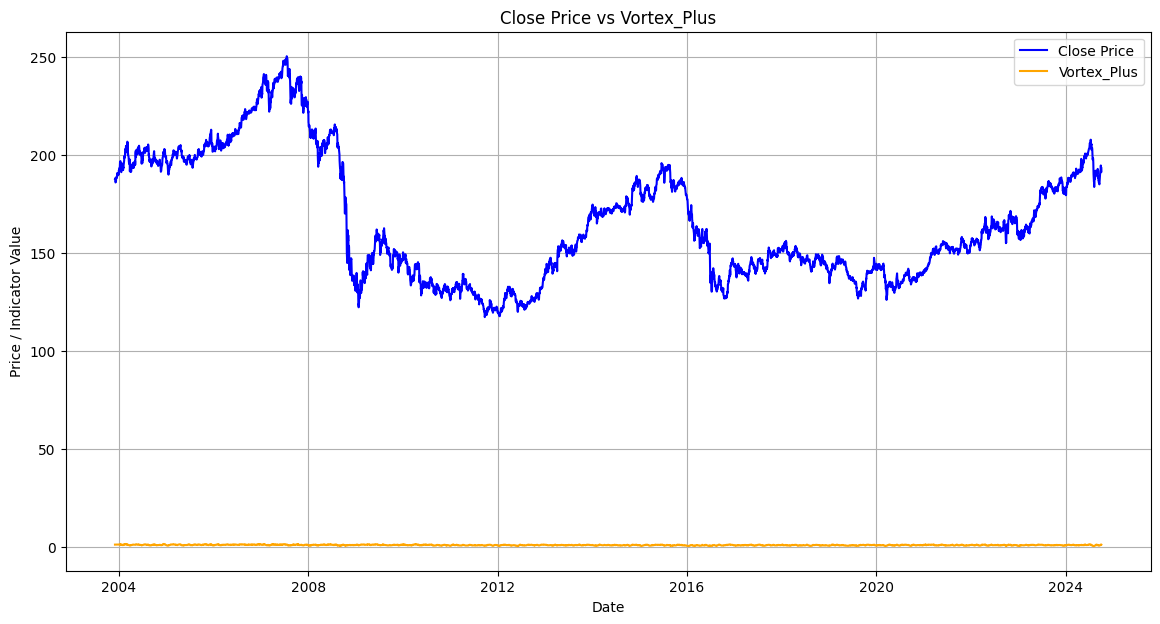

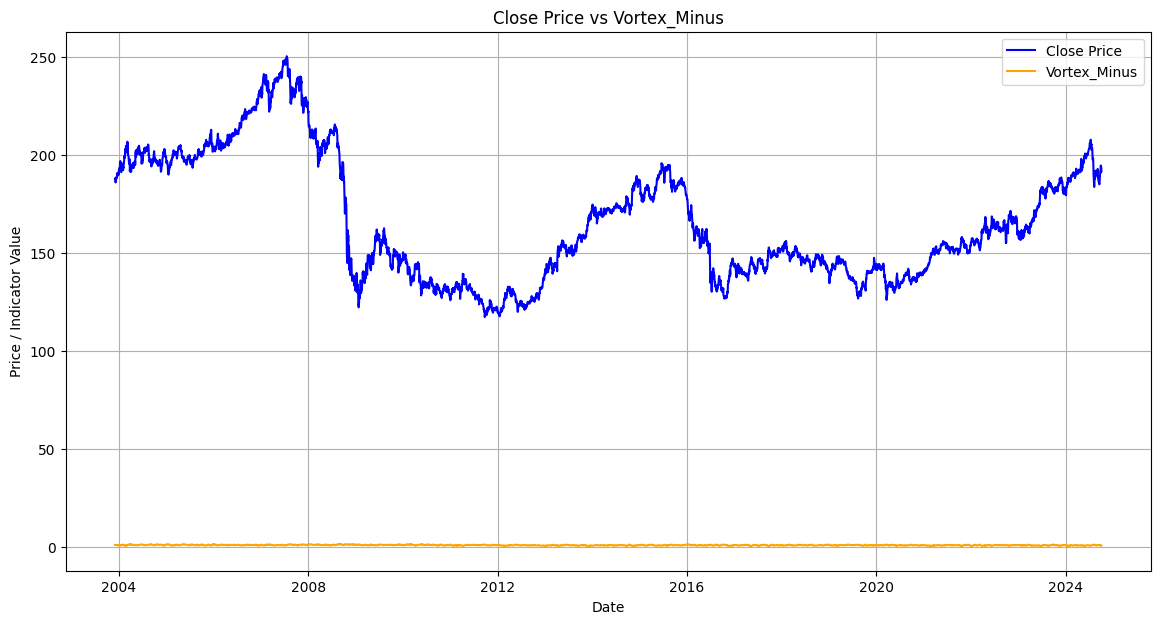

In [236]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 5 FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**5.1. Calculate MI and decide which feature has the highest correlation**

In [237]:
# Define the target variables
targets = ['Close', 'Open', 'High', 'Low']  # Add any other targets you want to consider

# Initialize a DataFrame to hold MI scores for each target
mi_results = pd.DataFrame()

# Separate features
X = data.drop(columns=['Date'] + targets)  # Exclude the target and date columns

# Calculate Mutual Information for each target variable
for target in targets:
    y = data[target]
    
    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame for the current target's MI scores
    mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=[f'MI Score_{target}'])
    
    # Append to the results DataFrame
    mi_results = pd.concat([mi_results, mi_df], axis=1)

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the MI scores for all targets
print("Mutual Information Scores for each target:")
print(mi_results)

Mutual Information Scores for each target:
              MI Score_Close  MI Score_Open  MI Score_High  MI Score_Low
Adj Close           7.317889       5.185462       3.905495      3.814529
Volume              0.000010       0.000099       0.000000      0.000016
MA_10               2.652928       2.712764       2.691052      2.631830
MA_50               2.108280       2.118342       2.193204      2.130438
MA_200              2.075603       2.085855       2.149859      2.094650
RSI                 0.208905       0.163489       0.164828      0.157851
MACD                0.383985       0.396053       0.384762      0.386044
BB_High             2.368796       2.405129       2.398959      2.372547
BB_Low              2.396268       2.423605       2.439787      2.364211
BB_Width            0.315575       0.306711       0.338024      0.309111
Volume_24h          0.000029       0.000080       0.000000      0.000002
ADL                 0.000016       0.000028       0.000000      0.000025
Aroon_Up

**5.2. Drop unrelated features**

In [238]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score for each target
features_to_drop = set()
for target in targets:
    low_mi_features = mi_results[mi_results[f'MI Score_{target}'] < mi_threshold].index.tolist()
    features_to_drop.update(low_mi_features)

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=list(features_to_drop))

# Optionally, update the DataFrame with the target
data_reduced = data.drop(columns=list(features_to_drop))

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power'],
      dtype='object')
Saved reduced data to: Dataset\GBPJPY=X_reduced_data.csv
          Date       Open       High        Low      Close  Adj Close  Volume  \
0   2003-12-01 189.330002 189.660004 187.740005 187.630005 187.630005       0   
1   2003-12-02 187.669998 188.809998 187.559998 188.009995 188.009995       0   
2   2003-12-03 188.020004 188.240005 186.490005 187.089996 187.089996       0   
3   2003-12-04 187.029999 187.029999 185.899994 186.220001 186.220001       0   
4   2003-12-05 186.190002 186.740005 185.830002 185.880005 185.880005       0   
..         ...        ...        ...        ...        ...        ...     ...   
995 2007-09-27 232.669998 234.449997 232.449997 234.130005 234.130005       0   
996 2007-09-28 234.080002 235.240005 232.479996 235.240005 235.240005       0 

# **STEP 6: PREPARE AND TRANSFORM DATA-FRAME**

In [239]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values

**6.1. Shift Label for future predictions**

In [240]:
k = -1
for target_column in targets:  # Iterate over each target
    data[target_column] = data[target_column].shift(k)

# Drop rows with NaN values created by the shift
data = data.dropna()

# Print some data 
print(data.head())

        Date       Open       High        Low      Close  Adj Close  Volume  \
0 2003-12-01 187.669998 188.809998 187.559998 188.009995 187.630005       0   
1 2003-12-02 188.020004 188.240005 186.490005 187.089996 188.009995       0   
2 2003-12-03 187.029999 187.029999 185.899994 186.220001 187.089996       0   
3 2003-12-04 186.190002 186.740005 185.830002 185.880005 186.220001       0   
4 2003-12-05 185.949997 186.699997 185.589996 186.179993 185.880005       0   

       MA_10      MA_50     MA_200  ...      ATR       AO       BOP  \
0 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.885416   
1 187.290999 191.452800 197.364300  ... 0.000000 4.871175  0.271997   
2 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.531433   
3 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.716809   
4 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.340655   

   Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc       CCI  Vortex_Plus  \
0    4.577199    2.357

**6.2. Split the data into training and test sets**

In [241]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Print out some information about the split
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4338 training + 1085 test examples
           Date       Open       High        Low      Close  Adj Close  \
2760 2014-07-15 174.304993 174.399994 174.052994 174.281998 173.470001   
4085 2019-08-15 128.278000 129.544006 128.139999 128.257996 127.699997   
1477 2009-08-11 158.682999 158.820007 158.539993 158.710007 158.110001   
75   2004-03-15 199.009995 199.029999 196.820007 197.039993 199.059998   

      Volume      MA_10      MA_50     MA_200  ...      ATR        AO  \
2760       0 174.230499 172.446300 168.814555  ... 0.985780  0.853749   
4085       0 128.505001 134.339221 141.074760  ... 1.475742 -5.117429   
1477       0 159.593700 156.937899 144.306329  ... 1.977952  4.191571   
75         0 202.202000 197.956200 197.364300  ... 2.752583  1.664796   

           BOP  Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc         CCI  \
2760 -0.027914    2.087696    0.833698     0.000000  37.080939    4.466976   
4085 -0.019217   

**6.3. Define features and targets**

In [242]:
feature_columns = data.columns.difference(['Date'] + targets).tolist()  # Define features excluding Date and targets
X_reduced = data.drop(columns=['Date'] + targets).drop(columns=list(features_to_drop))  

In [243]:
X_train = train_set[X_reduced.columns]
X_test = test_set[X_reduced.columns]

# Split targets for each label
y_train_dict = {target: train_set[target] for target in targets}
y_test_dict = {target: test_set[target] for target in targets}

**6.4. Define and Train Model Pipelines for Each Target**

In [244]:

# Redefine num_feat_names based on X_reduced
num_feat_names = X_reduced.columns.tolist()

In [245]:
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])


**6.4.2. Fit and Transform the Pipeline on training data**

In [246]:

# Run the pipeline to process training data
processed_train_set_val = num_pipeline.fit_transform(X_train)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with appropriate column names
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set

# Save the numerical pipeline
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')


____________ Processed feature values ____________
[[ 0.2558064   0.2810617   0.22283821  0.10227162  0.29160926  0.18388259
   0.34653196 -1.00414961 -1.12349743  0.23597888 -0.13445948  0.27781164
   0.31654576]
 [-1.21995373 -1.19604101 -1.01550794 -0.82170732 -1.47736348 -1.0265957
  -1.18474959  1.47258272 -0.47903384 -1.41563695 -0.10564664 -1.26733304
  -1.12059997]
 [-0.23944539 -0.19176106 -0.28113031 -0.71406766  1.00862101 -0.2046994
  -0.32856919  0.78087709  0.18153959  1.1592138  -2.14035193  0.15113842
   0.38047048]]
(4338, 13)


['models/num_pipeline.pkl']

# **STEP 7. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [247]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [248]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**7.1. Try Light GBM model.**

In [249]:
for target in targets:
    model = lgb.LGBMRegressor()  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ LGBMRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 13
[LightGBM] [Info] Start training from score 165.520577



____________ LGBMRegressor for Close ____________

R2 score (on training data, best=1): 0.9991523326360482
Root Mean Square Error:  0.9023996983029908

Predictions:  [191.17944823 182.96328899 171.9948133  144.83115145 143.86508229
 149.01790978 148.65575596 129.5907605  169.10895544]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as LGBMRegressor_model.pkl
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 13
[LightGBM] [Info] Start training from score 165.535104

____________ LGBMRegressor for Open ________

**7.2. Try XGBoost model.**

In [250]:
for target in targets:
    model = XGBRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ XGBoost_Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ XGBoost_Regressor for Close ____________

R2 score (on training data, best=1): 0.9997948144627543
Root Mean Square Error:  0.4439760908385985

Predictions:  [191.34929 183.04587 171.98973 144.6984  143.40074 148.55469 148.83154
 128.40666 168.81058]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as XGBRegressor_model.pkl

____________ XGBoost_Regressor for Open ____________

R2 score (on training data, best=1): 0.9998812187867305
Root Mean Square Error:  0.3379386000479417

Predictions:  [190.5138  183.68599 172.12454 144.78549 143.49068 149.01843 148.78462
 128.8905  167.85924]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999786376953, 167.6699981689453]
Model successfully saved as XGBRegresso

**7.3. Try Decision Tree (in-lecture).**

In [251]:
for target in targets:
    model = DecisionTreeRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ DecisionTreeRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ DecisionTreeRegressor for Close ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [190.96699524 183.07899475 171.05599976 145.28900146 143.61500549
 148.79200745 147.76100159 127.91999817 170.7480011 ]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as DecisionTreeRegressor_model.pkl

____________ DecisionTreeRegressor for Open ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [190.93200684 183.66999817 171.05400085 145.28900146 143.88000488
 148.94700623 147.82600403 129.3999939  169.1000061 ]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999786376953, 167.6699981689453]
Model successfully saved as 

**7.4. Try Polynomial Regression (in-lecture).**

In [252]:
for target in targets:
    degree = 2  # Degree of the polynomial
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Fit the model on the respective target
    model.fit(X_train, y_train_dict[target])

    print(f'\n____________ PolynomialRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    predictions = model.predict(X_test[:9]).round(decimals=1)
    print("\nPredictions: ", predictions)
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ PolynomialRegressor for Close ____________

R2 score (on training data, best=1): 0.9989045315742843
Root Mean Square Error:  1.0258553846387983

Predictions:  [190.7 182.5 171.3 145.1 143.2 148.9 148.  127.2 166.7]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for Open ____________

R2 score (on training data, best=1): 0.9996598220049203
Root Mean Square Error:  0.5718959627999226

Predictions:  [190.7 182.7 171.5 145.1 143.5 148.9 147.9 127.4 166.9]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999786376953, 167.6699981689453]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for High ____________

R2 score 

**7.5. Try Linear Regressor (in-lecture).**

In [253]:
for target in targets:
    model = LinearRegression() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Linear Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Linear Regressor for Close ____________

R2 score (on training data, best=1): 0.9986131335173035
Root Mean Square Error:  1.1542597090238471

Predictions:  [191.00391259 183.20480261 171.36471286 145.15852815 143.66157784
 148.82872514 147.91241811 128.38077008 167.07046741]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as LinearRegression_model.pkl

____________ Linear Regressor for Open ____________

R2 score (on training data, best=1): 0.9994608005045555
Root Mean Square Error:  0.7200102195743329

Predictions:  [190.94212158 183.24782385 171.4918695  145.09333233 143.74180165
 148.8017065  147.92659356 128.25095119 167.29350677]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999786376953, 16

**7.6. Try Random Forest (in-lecture).**

In [254]:
for target in targets:
    model = RandomForestRegressor(n_estimators=20) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ RandomForestRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ RandomForestRegressor for Close ____________

R2 score (on training data, best=1): 0.9996991216896439
Root Mean Square Error:  0.537627717634134

Predictions:  [190.62430344 182.90620041 171.58075027 145.39045105 143.7202034
 148.96360092 148.4309761  129.43579636 168.72115021]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as RandomForestRegressor_model.pkl

____________ RandomForestRegressor for Open ____________

R2 score (on training data, best=1): 0.9998554672176566
Root Mean Square Error:  0.3727752788306011

Predictions:  [190.65565186 183.18704987 171.86965103 145.19345169 143.38460312
 149.01560364 148.29509888 129.33719788 169.34035034]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999

**7.7. Try K-Nearest-Neighbor**

In [255]:
for target in targets:
    model = KNeighborsRegressor(n_neighbors=5) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ KNeighborRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ KNeighborRegressor for Close ____________



R2 score (on training data, best=1): 0.997254313703446
Root Mean Square Error:  1.624095893288588

Predictions:  [189.9690033  181.00319824 164.14460144 144.96719971 139.65740356
 149.55639954 147.80700073 128.68599854 168.29379883]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as KNeighborsRegressor_model.pkl

____________ KNeighborRegressor for Open ____________

R2 score (on training data, best=1): 0.997673523879487
Root Mean Square Error:  1.4955923040936265

Predictions:  [189.9690033  180.97999573 164.13099976 144.94740295 139.33079834
 149.52780151 147.83439636 128.67320099 168.29379883]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.73999786376953, 167.6699981689453]
Model successfully saved as KNeighb

**7.8. Try using SVR**

In [256]:
for target in targets:
    model = SVR(kernel='rbf')  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Support Vector Regressor (SVR) for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Support Vector Regressor (SVR) for Close ____________

R2 score (on training data, best=1): 0.9851626686494918
Root Mean Square Error:  3.775409878788362

Predictions:  [190.38793327 183.38163842 170.41873534 144.97380732 143.01368033
 148.34618677 147.44645452 132.48044732 165.2883944 ]
Labels:       [190.6199951171875, 182.59800720214844, 170.36199951171875, 144.73699951171875, 144.86000061035156, 148.81300354003906, 148.16299438476562, 126.79000091552734, 167.6699981689453]
Model successfully saved as SVR_model.pkl

____________ Support Vector Regressor (SVR) for Open ____________

R2 score (on training data, best=1): 0.9857414405020727
Root Mean Square Error:  3.7025569583690436

Predictions:  [190.29700133 183.32877611 170.58234072 144.95874544 143.06333145
 148.33987323 147.48385638 132.45008038 165.4331487 ]
Labels:       [190.6199951171875, 182.59800720214844, 170.34500122070312, 144.71299743652344, 143.65699768066406, 148.8070068359375, 148.177001953125, 126.7399

# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**

In [257]:
# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**
print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5, shuffle=True, random_state=37)  # cv data generator

run_new_evaluation = 1  # Set to 1 for new evaluation; 0 to load results
filename_prefix = "your_prefix"  # Change this to your desired prefix

if run_new_evaluation:
    models = {
        "LinearRegression": LinearRegression(),
        "LGBMRegressor": lgb.LGBMRegressor(),
        "XGBoost": XGBRegressor(),
        "DecisionTreeRegressor": DecisionTreeRegressor(),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=20),
        "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel='rbf')
    }
    
    for model_name, model in models.items():
        for target in targets:
            print(f"\nEvaluating {model_name} for {target}...")
            y_train = y_train_dict[target]
            
            nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
            rmse_scores = np.sqrt(-nmse_scores)
            
            # Save RMSE scores
            joblib.dump(rmse_scores, f'saved_objects/{model_name}_rmse_{target}.pkl')
            print(f"{target} - {model_name} rmse: ", rmse_scores)
            print(f"{target} - Avg. rmse: ", mean(rmse_scores), '\n')

            # Step 2: Predict using cross-validation
            y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
            
            # Step 3: Calculate residuals
            residuals = y_train - y_train_pred
            
            # Step 4: Plot the residual distribution
            plt.figure()
            plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
            plt.title(f'{target} - {model_name} Residual Distribution')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.savefig(f'models/{filename_prefix}_{target}_{model_name}_residuals_plot.png')  # Save with target name
            plt.close()  # Close the plot to free memory
else: 
    # Load RMSE scores from previously saved files
    for model_name in ["LinearRegression", "LGBMRegressor", "XGBoost", "DecisionTreeRegressor", "RandomForestRegressor", "KNeighborsRegressor", "SVR"]:
        for target in targets:
            rmse_scores = joblib.load(f'saved_objects/{model_name}_rmse_{target}.pkl')
            print(f"\n{model_name} rmse for {target}: ", rmse_scores)
            print(f"Avg. rmse for {target}: ", mean(rmse_scores), '\n')



____________ K-fold cross validation ____________

Evaluating LinearRegression for Close...
Close - LinearRegression rmse:  [1.23893205 1.22309074 1.20492384 1.07656974 1.12491089]
Close - Avg. rmse:  1.1736854538303565 


Evaluating LinearRegression for Open...
Open - LinearRegression rmse:  [0.74641067 0.77213438 0.67447882 0.7310771  0.73149052]
Open - Avg. rmse:  0.7311182977077881 


Evaluating LinearRegression for High...
High - LinearRegression rmse:  [1.01779542 1.06702816 1.03500718 1.01201205 0.98823677]
High - Avg. rmse:  1.0240159151450863 


Evaluating LinearRegression for Low...
Low - LinearRegression rmse:  [1.37456603 1.17558452 1.33322569 1.12790446 1.09423071]
Low - Avg. rmse:  1.2211022807286382 


Evaluating LGBMRegressor for Close...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the ov

**STEP 9: FINE-TUNING**

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from lightgbm import LGBMRegressor
import joblib

print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name + " ======")
    print('Best hyperparameter combination: ', grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

cv = KFold(n_splits=5, shuffle=True, random_state=37)

run_new_search = 1  # Set to 1 to run a new search, 0 to load previous results
if run_new_search:
    # Define a parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 500],  # Number of boosting iterations (trees) to be built.
        'max_depth': [3, 5, 7, 10],  # Maximum depth of each tree.
        'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
        'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training each tree
        'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training each tree
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
    }
    
    # Set up and run grid search
    lgb_model = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "LGBMRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="LGBMRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)



____________ Fine-tune models ____________
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 13
[LightGBM] [Info] Start training from score 164.701438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

# **STEP 10:  PREDICT THE PRICE FOR THE NEXT 7 DAYS USING ALL PAST DATA**

In [259]:
print(X_test.columns)

Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power'],
      dtype='object')


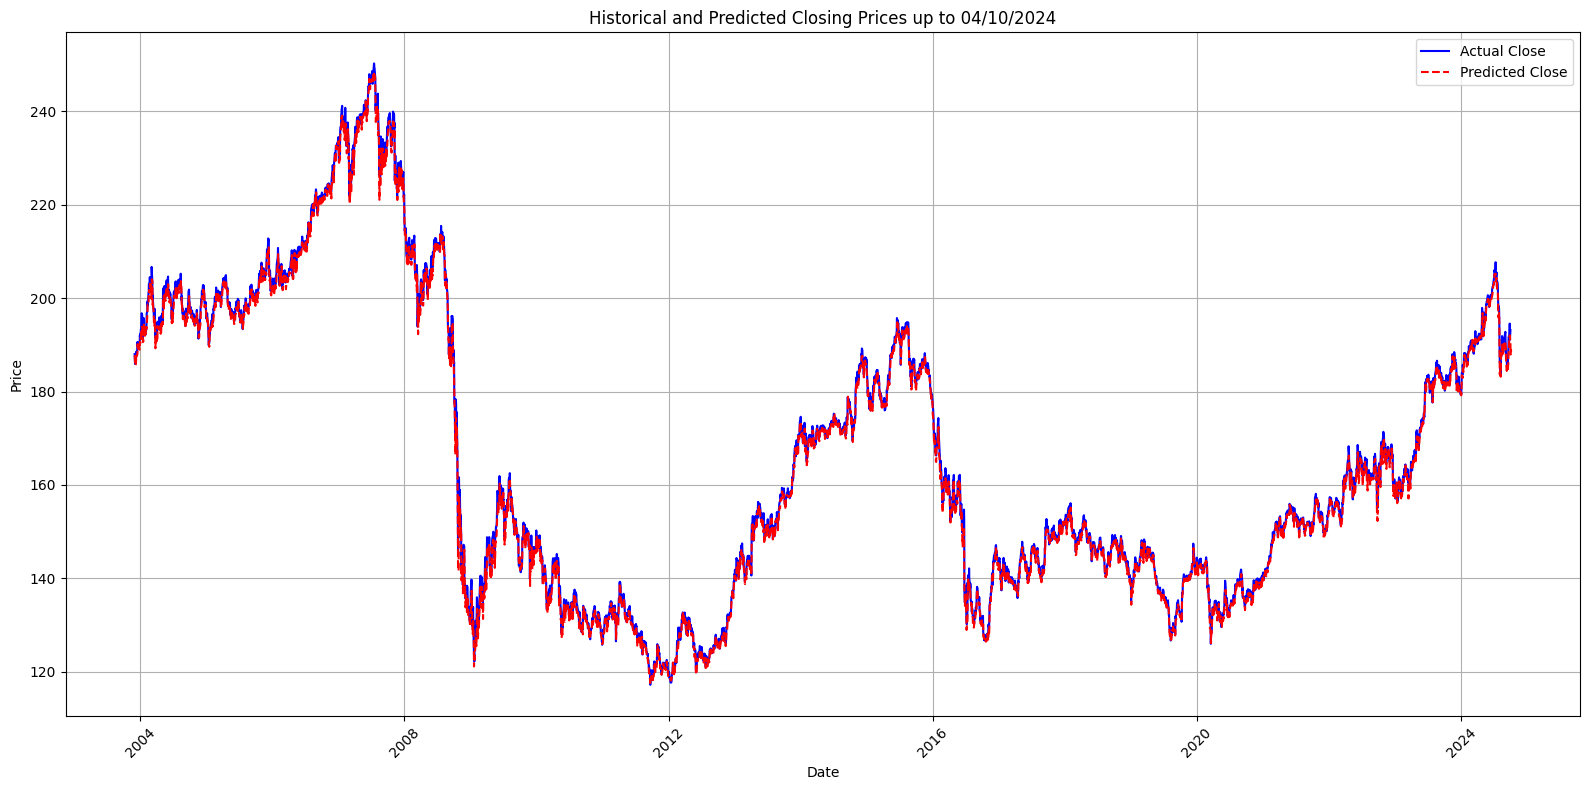

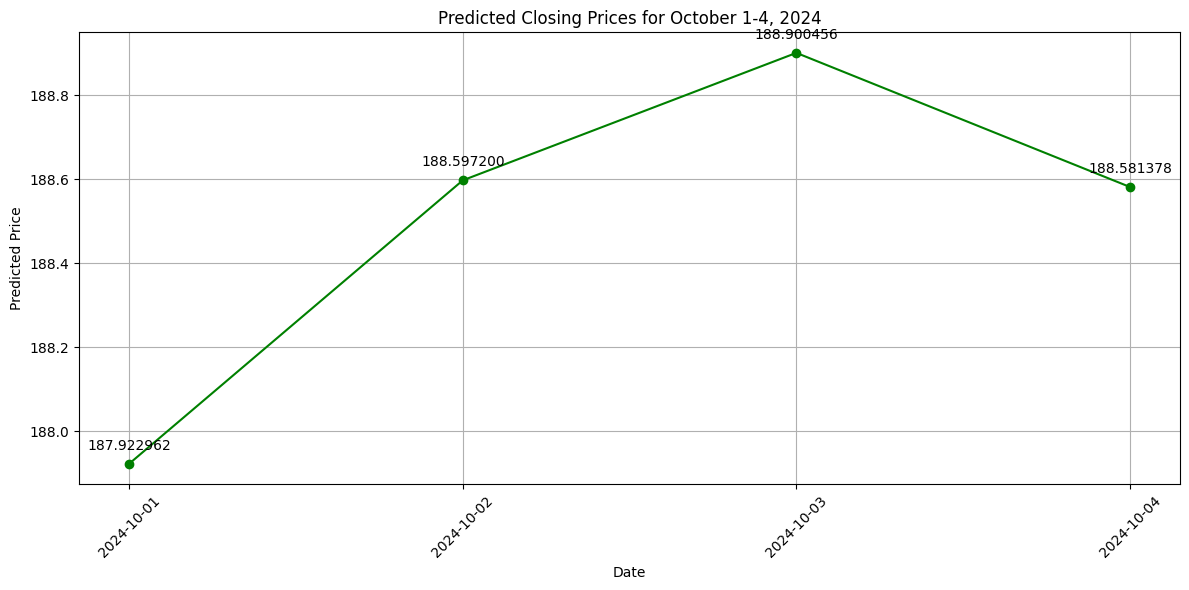


Predictions for specific dates:

Model Performance on Historical Data:
R2 Score: 0.9980752180
RMSE: 1.3622845691

Predictions saved to 'forex_predictions_to_2024-10-04.csv'


In [260]:
# **STEP 10: FINAL PREDICTION AND VISUALIZATION USING LIGHTGBM**

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import r2_score, mean_squared_error

# Load the trained LightGBM model from step 9
lightgbm_model = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl').best_estimator_

# Load the numerical pipeline
num_pipeline = joblib.load('models/num_pipeline.pkl')

def generate_future_features(last_data, end_date):
    days = (end_date - last_data['Date'].iloc[-1]).days
    future_dates = pd.date_range(start=last_data['Date'].iloc[-1] + timedelta(days=1), periods=days)
    
    future_data = pd.DataFrame({'Date': future_dates})
    
    # Add time-based features
    future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
    future_data['Month'] = future_data['Date'].dt.month
    future_data['Year'] = future_data['Date'].dt.year
    
    # For other features, use a simple time series forecast (e.g., moving average) with some noise
    for col in last_data.columns:
        if col not in ['Date', 'DayOfWeek', 'Month', 'Year'] + targets:
            mean_value = last_data[col].rolling(window=30).mean().iloc[-1]
            std_value = last_data[col].rolling(window=30).std().iloc[-1]
            future_data[col] = np.random.normal(mean_value, std_value * 0.1, size=len(future_data))
    
    return future_data

# Get the last data point from your original dataset
last_data = data.copy()

# Add time-based features to historical data
last_data['DayOfWeek'] = last_data['Date'].dt.dayofweek
last_data['Month'] = last_data['Date'].dt.month
last_data['Year'] = last_data['Date'].dt.year

# Set the end date for prediction
end_date = datetime(2024, 10, 4)

# Generate future features
future_data = generate_future_features(last_data, end_date)

# Combine historical and future data
combined_data = pd.concat([last_data, future_data], ignore_index=True)

# Prepare features for the entire dataset
X_combined = combined_data.drop(columns=['Date'] + targets)
X_combined = num_pipeline.transform(X_combined)

# Make predictions for the entire dataset
all_predictions = lightgbm_model.predict(X_combined)

# Add some noise to the predictions to simulate market fluctuations
noise = np.random.normal(0, 0.0005, size=len(all_predictions))
all_predictions += noise

# Create a DataFrame with all dates and predictions
prediction_df = pd.DataFrame({
    'Date': combined_data['Date'],
    'Actual_Close': combined_data['Close'],
    'Predicted_Close': all_predictions
})

# Visualize the predictions
plt.figure(figsize=(16, 8))
plt.plot(prediction_df['Date'], prediction_df['Actual_Close'], label='Actual Close', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--')
plt.title('Historical and Predicted Closing Prices up to 04/10/2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# New plot for October 1-4, 2024
oct_data = prediction_df[(prediction_df['Date'] >= '2024-10-01') & (prediction_df['Date'] <= '2024-10-04')]

plt.figure(figsize=(12, 6))
plt.plot(oct_data['Date'], oct_data['Predicted_Close'], marker='o', linestyle='-', color='green')
plt.title('Predicted Closing Prices for October 1-4, 2024')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.xticks(oct_data['Date'], [date.strftime('%Y-%m-%d') for date in oct_data['Date']], rotation=45)
for i, price in enumerate(oct_data['Predicted_Close']):
    plt.annotate(f'{price:.6f}', (oct_data['Date'].iloc[i], price), textcoords="offset points", xytext=(0,10), ha='center')
plt.tight_layout()
plt.show()

# Print the predictions for specific dates
print("\nPredictions for specific dates:")
specific_dates = [
    datetime(2023, 12, 31),
    datetime(2024, 3, 31),
    datetime(2024, 6, 30),
    datetime(2024, 10, 1),
    datetime(2024, 10, 2),
    datetime(2024, 10, 3),
    datetime(2024, 10, 4)
]

for date in specific_dates:
    if date in prediction_df['Date'].values:
        pred = prediction_df[prediction_df['Date'] == date]['Predicted_Close'].values[0]
        print(f"{date.strftime('%Y-%m-%d')}: {pred:.10f}")

# Evaluate the model on the historical data
historical_mask = prediction_df['Actual_Close'].notna()
y_true = prediction_df.loc[historical_mask, 'Actual_Close']
y_pred = prediction_df.loc[historical_mask, 'Predicted_Close']

r2score = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\nModel Performance on Historical Data:")
print(f"R2 Score: {r2score:.10f}")
print(f"RMSE: {rmse:.10f}")

# Save predictions to CSV without rounding
prediction_df.to_csv('forex_predictions_to_2024-10-04.csv', index=False, date_format='%Y-%m-%d', float_format='%.10f')
print("\nPredictions saved to 'forex_predictions_to_2024-10-04.csv'")
